<a href="https://colab.research.google.com/github/Francesca-Rossi/ITA_university_advisor/blob/main/Italian_university_advisor_backup_10_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importazione librerie

In [1012]:
import gspread 
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import os
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
import json as js


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#COLLEGAMENTO CON IL GOOGLE SHEET 

In [1013]:
SCOPES = ["https://spreadsheets.google.com/feeds",
                  "https://www.googleapis.com/auth/spreadsheets",
                  "https://www.googleapis.com/auth/drive",
                  "https://www.googleapis.com/auth/drive"]
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/big data proj")
cred = ServiceAccountCredentials.from_json_keyfile_name("/content/drive/My Drive/Colab Notebooks/big data proj/GoogleSheetCredentials.json", SCOPES)
gclient = gspread.authorize(cred)
sheet = gclient.open_by_url("https://docs.google.com/spreadsheets/d/1scMc0UlNC1pdZNow5k3pLhofcW6j4ekXyxYlNiBcueI/edit?usp=sharing")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RECUPERO FOGLI E SALVATAGGIO IN DATAFRAME

In [1014]:
students_data = sheet.worksheet('Laureando').get_all_records()
graduate_data = sheet.worksheet('Laureato').get_all_records()

In [1015]:
df_students = pd.DataFrame(students_data)
df_graduate = pd.DataFrame(graduate_data)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 88)
graduates shape: (61, 85)


##RIMOZIONE FEATURES RELATIVE AD UN ALTRO PROGETTO

In [1016]:
df_students = df_students.drop(df_students.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
df_graduate = df_graduate.drop(df_graduate.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 79)
graduates shape: (61, 76)


#ANALISI VALORI MANCANTI

##Sostituzione celle vuote con valore 'Nan'

In [1017]:
df_students=df_students.replace('',np.NaN)
df_graduate=df_graduate.replace('',np.NaN)

##Somma valori mancanti per ogni features

In [1018]:
df_missing_value_students=df_students.isnull().sum()
df_missing_value_graduate=df_graduate.isnull().sum()

#FUNZIONI GRAFICI VALORI MANCANTI

In [1019]:
#manage colors
def missing_value_colors(values, tot):
  clrs=[]
  for x in values:
    x_perc= (x/tot)*100
    if (x_perc<=75):
      clrs.append('g') #green when missing value < 75%
    elif (x_perc>75) and (x_perc<=85):
      clrs.append('y')
    else:
      clrs.append('r')
  return clrs


In [1020]:
def missing_value_graphs(dataframe_missing_value, original_df, title):
  #variable
  tot_values=original_df.shape[0] 
  print(tot_values)
  values=dataframe_missing_value.values
  row_index=dataframe_missing_value.index
  start=0
  for i in range(2, 0, -1):
    end=int(len(row_index)/i)
    title_str=f'{title} missing values from {row_index[start]} to {row_index[end-1]}'
    #graphs
    fig, ax = plt.subplots(figsize =(10, 12))
    colors=missing_value_colors(values, tot_values)
    ax.barh(row_index[start:end], values[start:end], color=colors[start:end])   # Horizontal Bar Plot
    ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)   # Add x, y gridlines
    for i in ax.patches: 
        plt.text(i.get_width()+0.2, i.get_y()+0.5,str(round(((i.get_width()/tot_values)*100), 2))+'%',
                fontsize = 10, fontweight ='bold',color ='grey')   # Add annotation to bars
    ax.invert_yaxis()   # Show top values
    #labeling
    plt.xlabel("Missing values")
    plt.ylabel("Features")
    plt.title(title_str)
    plt.show() #show the graphs
    start=end

##STUDENTI: grafico valori mancanti

719


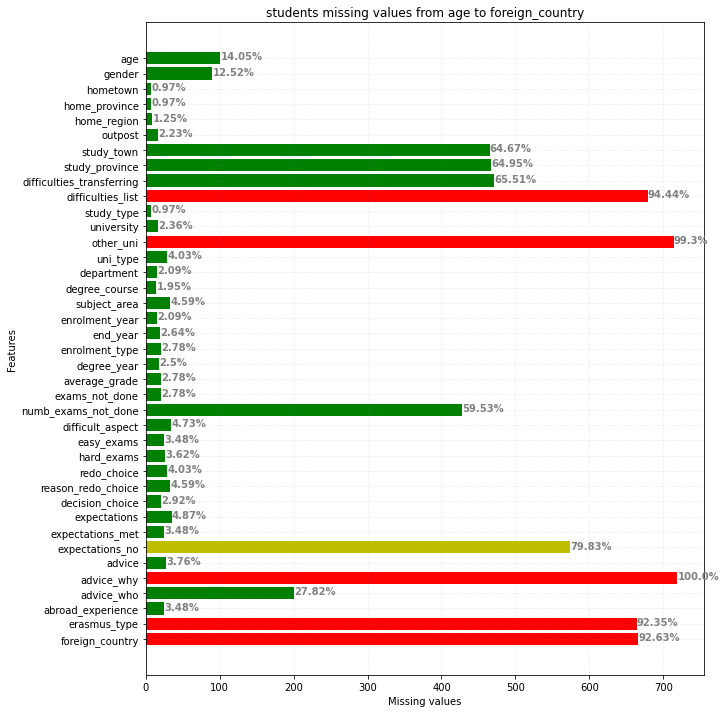

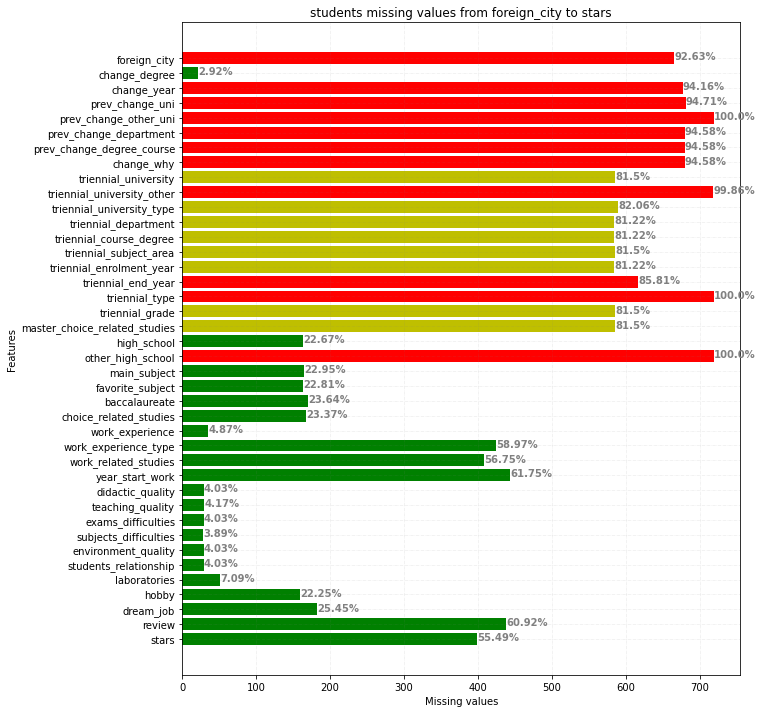

In [1021]:
missing_value_graphs(df_missing_value_students, df_students, 'students')

##LAUREATI: grafico valori mancanti

61


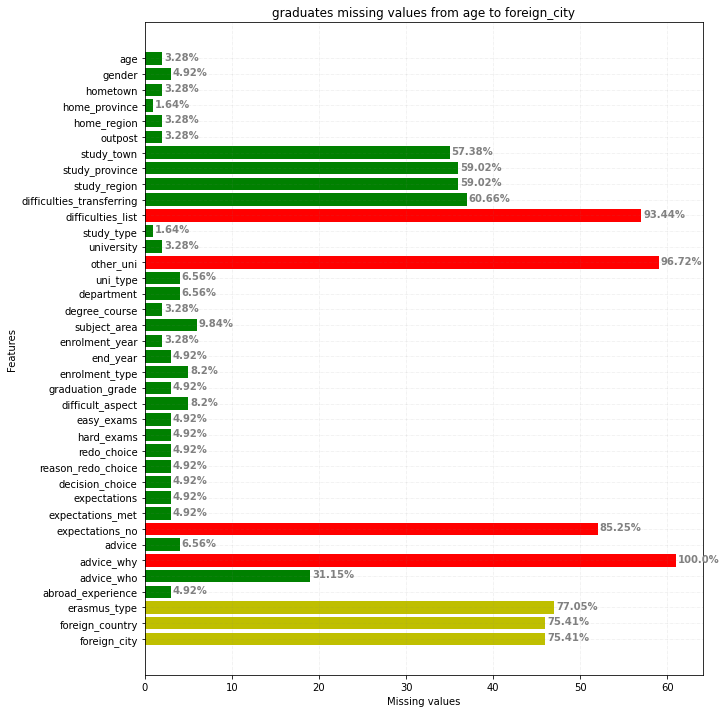

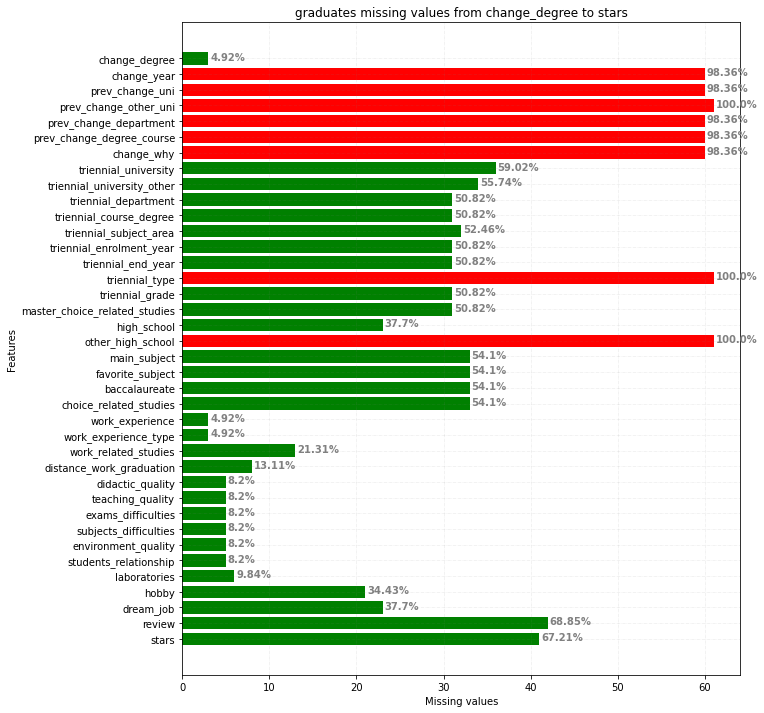

In [1022]:
missing_value_graphs(df_missing_value_graduate, df_graduate, 'graduates')

#GESTIONE VALORI MANCANTI NELLA COLONNA UNIVERSITA'

##Studenti

###1 - Sostituzione altro con valore 'Nan'

In [1023]:
df_students['university']=df_students['university'].replace('altro', np.NaN ) #necessario per effettuare merge tra 2 colonne
df_students.shape

(719, 79)

In [1024]:
#TODO remove [fra]
df_students[['university', 'other_uni']].head(50) #codice di controllo

,university,other_uni
0,Politecnico di MILANO,NaN
1,Università degli Studi di NAPOLI Federico II,NaN
2,Università degli Studi di ROMA La Sapienza,NaN
3,Università degli Studi di ROMA La Sapienza,NaN
4,Università degli Studi di CAGLIARI,NaN
5,Università degli Studi di PARMA,NaN
6,NaN,"Civica Scuola di Cinema ""Luchino Visconti"""
7,Università degli Studi di BOLOGNA,NaN
8,Università degli Studi di PARMA,NaN
9,Università degli Studi di PARMA,NaN


###2- Merge tra la colonna university e other_uni per unire i valori mancanti in university

In [1025]:
df_students['university']=df_students['university'].combine_first(df_students['other_uni'])
#df_students['university'].head(50)

### 3 - Eliminazione delle righe che nonostante il merge presentano valori nulli nella colonna university

In [1026]:
df_students = df_students[df_students['university'].notna()]
df_students.shape

(696, 79)

##Laureati

### 1- Sostituzione altro con il valore 'Nan'

In [1027]:

df_graduate['university']=df_graduate['university'].replace('altro', np.NaN ) #per poter fare il merge tra due colonne
df_graduate.shape

(61, 76)

In [1028]:
#TODO remove [fra]
df_graduate.isnull().sum() #codice di controllo

age               2
gender            3
hometown          2
home_province     1
home_region       2
                 ..
laboratories      6
hobby            21
dream_job        23
review           42
stars            41
Length: 76, dtype: int64

In [1029]:
#TODO remove [fra]
df_graduate[['university', 'other_uni']].head(50) #codice di controllo

,university,other_uni
0,Università degli Studi di PARMA,NaN
1,Università degli Studi di PARMA,NaN
2,Università degli Studi di PARMA,NaN
3,Università degli Studi di PARMA,NaN
4,Università degli Studi di VERONA,NaN
5,Università degli Studi di MODENA e REGGIO EMILIA,NaN
6,Università degli Studi di PARMA,NaN
7,Università degli Studi di NAPOLI Federico II,NaN
8,Università degli Studi di PADOVA,NaN
9,Università degli Studi di ROMA Foro Italico,NaN


### 2- Merge tra colonna university e other_uni

In [1030]:
df_graduate['university']=df_graduate['university'].combine_first(df_graduate['other_uni'])
#df_graduate['university'].head(50)

###3- Eliminazione delle righe che contengono ancora 'Nan' nella colonna university

In [1031]:
df_graduate = df_graduate[df_graduate['university'].notna()]
df_graduate.shape

(57, 76)

#GESTIONE VALORI MANCANTI

###Colonna degree_course -> eliminazione celle nulle

In [1032]:
df_students = df_students[df_students['degree_course'].notna()]
df_students.shape

(690, 79)

In [1033]:
df_graduate = df_graduate[df_graduate['degree_course'].notna()]
df_graduate.shape

(57, 76)

#PREPROCESSING COLONNA DEGREE_COURSE

In [1034]:
#acronimi
slang_degree_course={"ctf":"chimica e tecnologie farmaceutiche",
       "clemi": "economia e marketing internazionale", 
       "sztpa": "scienze zootecniche e tecnologie delle produzioni animali", 
       "smid": "statistica matematica e trattamento informatico dati", 
       "clei": "economia internazionale",
       "clem": "economia e marketing", 
       "dams": "discipline delle arti della musica e dello spettacolo",
       "ctc": "chimica e tecnologie chimiche",
       "pmts": "planning management of tourism systems",
       "eifi":  "lingue moderne comunicazione cooperazione internazionale",
       "lms":  "letteratura musica spettacolo"
        }
#caratteri speciali
special_char=[',',"’","'",'<', '>', '.', '-', '_', '/', ': ', ' & ']

###Unisco i corsi di laurea dei due fogli

In [1035]:
#unisco studenti e laureati
all_degree_course=df_students['degree_course']
all_degree_course=all_degree_course.append(df_graduate['degree_course'])
all_degree_course.shape

(747,)

In [1036]:
#lo trasformo in frame se no mi genera dei problemi
all_degree_course=all_degree_course.to_frame()
#all_degree_course

In [1037]:
all_degree_course['clean_degree_course']=all_degree_course['degree_course']

In [1038]:
#metto in minuscolo
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].apply(lambda x: x.lower())
#df_students['degree_course'].head(50)

###Cleaning dei dati

In [1039]:
for key in slang_degree_course.keys():
  all_degree_course.loc[all_degree_course['clean_degree_course'].str.contains(key), 'clean_degree_course'] = slang_degree_course[key]
#df_students[['clean_degree_course','degree_course']].head(50)

In [1040]:
all_degree_course.loc[all_degree_course['clean_degree_course'].str.contains('medicina') & ~all_degree_course['clean_degree_course'].str.contains('veterinaria'), 'clean_degree_course'] = 'medicina e chirurgia'
all_degree_course.loc[all_degree_course['clean_degree_course'].str.contains('informatica') & all_degree_course['clean_degree_course'].str.contains('elettronica') & all_degree_course['clean_degree_course'].str.contains('telecomunicazioni') , 'clean_degree_course'] = 'ingegneria informatica elettronica e telecomunicazioni'
all_degree_course.loc[all_degree_course['clean_degree_course'].str.contains('comunicazione e media per le industrie creative'), 'clean_degree_course'] = 'comunicazione e media contemporanei per le industrie creative'
all_degree_course.loc[all_degree_course['clean_degree_course'].str.contains('elettronica') & ~all_degree_course['clean_degree_course'].str.contains('ingegneria' )& ~all_degree_course['clean_degree_course'].str.contains('ing'), 'clean_degree_course'] = 'ingegneria elettronica'
all_degree_course.loc[all_degree_course['clean_degree_course'].str.contains('interfacce e tecnologie della comunicazion'), 'clean_degree_course'] = 'interfacce uomo macchina e tecnologie della comunicazione'
all_degree_course.loc[all_degree_course['clean_degree_course'].str.contains('letteratura musica e spettacolo'), 'clean_degree_course'] = 'letteratura musica e spettacolo'
#df_students['clean_degree_course']

In [1041]:
#eliminare i corso di laurea
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace('corso di laurea', '')

In [1042]:
#rimozione di caratteri speciali
for i in range(0, len(special_char)):
  all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace(special_char[i], ' ')
#df_students['degree_course'].head(50)

In [1043]:
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace(r'\sl.*[0-9]+', '') #lm19 , l-12
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace('ingegneria ', 'ing ')
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace('ingeneria ', 'ing ')
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace(' ciclo unico', '')
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace(r'\scurriculum\s.*', '')
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace(r'indirizzo.*', '')
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace(r'[(].*[)]*', '')
#df_students.loc[df_students['clean_degree_course'].str.contains(r'l.*[0-9]+'), 'clean_degree_course'] 

In [1044]:
#eliminazione spazi bianchi prima e dopo una stringa
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.strip()
#df_students['degree_course'].head(50)

In [1045]:
#elimino doppi spazi bianchi
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].str.replace('  ', ' ')

In [1046]:
# Split the sentences to lists of words.
all_degree_course['clean_degree_course'] = all_degree_course['clean_degree_course'].str.split()
all_degree_course['clean_degree_course'] 

0                                   [ing, aerospaziale]
1                              [economia, e, commercio]
2                              [medicina, e, chirurgia]
3                                 [psicologia, clinica]
4                              [medicina, e, chirurgia]
                            ...                        
56    [scienze, dell, educazione, scienze, pedagogic...
57                                   [scienze, motorie]
58                                  [servizio, sociale]
59                                   [ing, informatica]
60                     [beni, culturali, e, spettacolo]
Name: clean_degree_course, Length: 747, dtype: object

In [1047]:
stop_ita = stopwords.words('italian')
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].apply(lambda x: [item for item in x if item not in stop_ita])
#stop_ita

In [1048]:
stop_en = stopwords.words('english')
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].apply(lambda x: [item for item in x if item not in stop_en])
#stop_en

In [1049]:
stemmer = ItalianStemmer()
all_degree_course['clean_degree_course'] = all_degree_course['clean_degree_course'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
#df_students['clean_degree_course'] 

In [1050]:
#Ricompongo le frasi
all_degree_course['clean_degree_course']=all_degree_course['clean_degree_course'].apply(' '.join)

In [1051]:
#TODO remove fra (codice di prova)
all_degree_course[['clean_degree_course','degree_course']].head(50)

,clean_degree_course,degree_course
0,ing aerospazial,ingegneria aerospaziale
1,econom commerc,Economia e commercio
2,medicin chirurg,Medicina
3,psicolog clinic,Psicologia clinica
4,medicin chirurg,Medicina e chirurgia
5,infermierist,Infermieristica
6,montagg cinematograf televis,Montaggio Cinematografico e Televisivo
7,lingu cultur italian stranier,Lingua e cultura italiane per stranieri
8,profession sanitar,Professioni Sanitarie
9,matemat,Matematica


In [1052]:
unique_degree_course=np.unique(all_degree_course['clean_degree_course'])
print(len(unique_degree_course))
print(unique_degree_course)

268
['advanced sportsc manufacturing' 'amministr direzion aziendal'
 'amministr finanz' 'analis process social'
 'applied experimental psychological sciences' 'archeolog' 'architettur'
 'arti scienz spettacol' 'artificial intelligenc robotics'
 'autom industrial' 'automation control engineering' 'banc finanz'
 'ben artist spettacol' 'ben cultural' 'ben cultural spettacol'
 'bioingegner' 'biolog' 'biolog ecolog marin' 'biolog molecol'
 'biolog molecol applic nutrizion' 'biolog sperimental applic'
 'biomedical engineering' 'bionanotecnolog' 'biotecnolog'
 'biotecnolog medic' 'biotecnolog sicurezz qualit agro aliment' 'chimic'
 'chimic clinic forens sport' 'chimic industrial' 'chimic tecnolog chimic'
 'chimic tecnolog farmaceut' 'civilt lingu stran mod' 'computer scienc'
 'comun' 'comun impres risors uman'
 'comun med contemporane industr creativ' 'comun med pubblic'
 'cultur digital comun' 'dat scienc' 'design' 'design prodott industrial'
 'design prodott nautic' 'dietist' 'digital marke

In [1053]:
#TODO: remove francesca
#df_students['uni-course'] = df_students['university'].str.cat(df_students['degree_course'],sep=" ")
#df_students['uni-course']

In [1054]:
#df_graduate['uni-course'] = df_graduate['university'].str.cat(df_graduate['degree_course'],sep=" ")
#df_graduate['uni-course']

#DATI TRIENNALE E MAGISTRALE CICLO UNICO

<p>Selezionare le righe secondo una determinata condizione</p>
<a href="https://chrisalbon.com/python/data_wrangling/pandas_selecting_rows_on_conditions/"> https://chrisalbon.com/python/data_wrangling/pandas_selecting_rows_on_conditions/</a>

In [1055]:
query_first_degree='study_type == "Triennale" | study_type == "Magistrale_unico"'
df_students_first_degree = df_students.query(query_first_degree)
df_graduate_first_degree = df_graduate.query(query_first_degree)
print('students first degree:',df_students_first_degree.shape)
print('graduates first degree:',df_graduate_first_degree.shape)


students first degree: (552, 79)
graduates first degree: (27, 76)


##ANALISI VALORI MANCANTI

In [1056]:
df_missing_value_first_degree_students=df_students_first_degree.isnull().sum()
df_missing_value_first_degree_graduate=df_graduate_first_degree.isnull().sum()

###STUDENTI TRIENNALE E MAISTRALE A CICLO UNICO:grafico valori mancanti

552


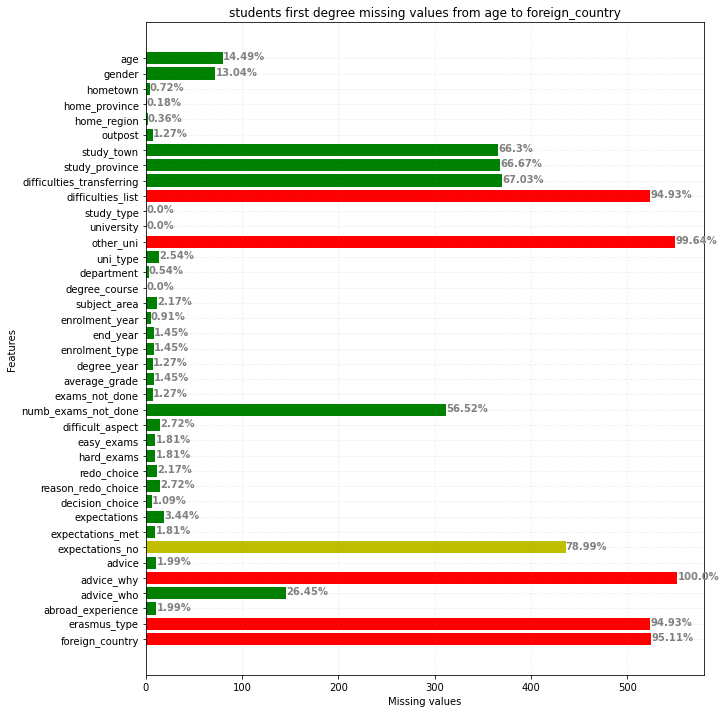

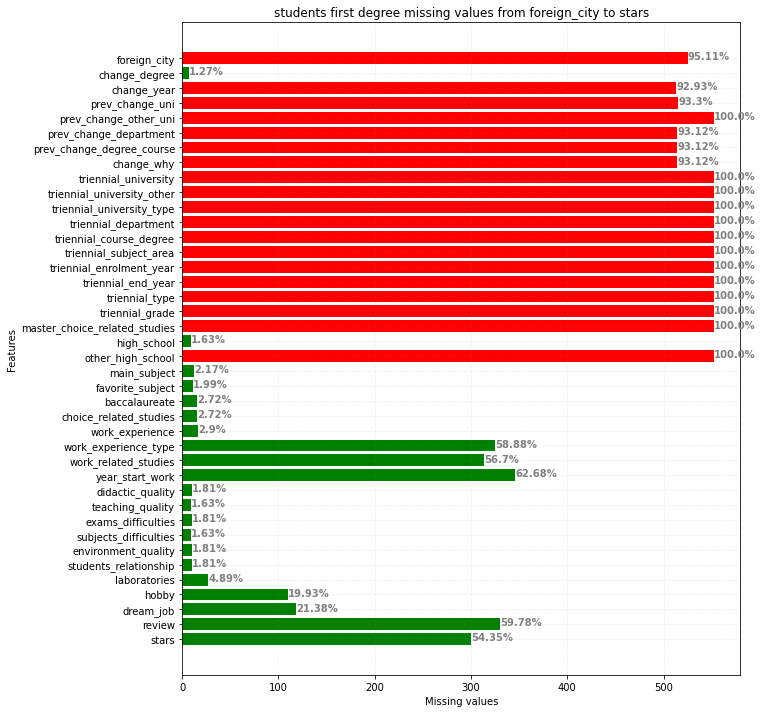

In [1057]:
missing_value_graphs(df_missing_value_first_degree_students, df_students_first_degree, 'students first degree')

###LAUREATI TRIENNALE E MAGISTRALE A CICLO UNICO:grafico valori mancanti

27


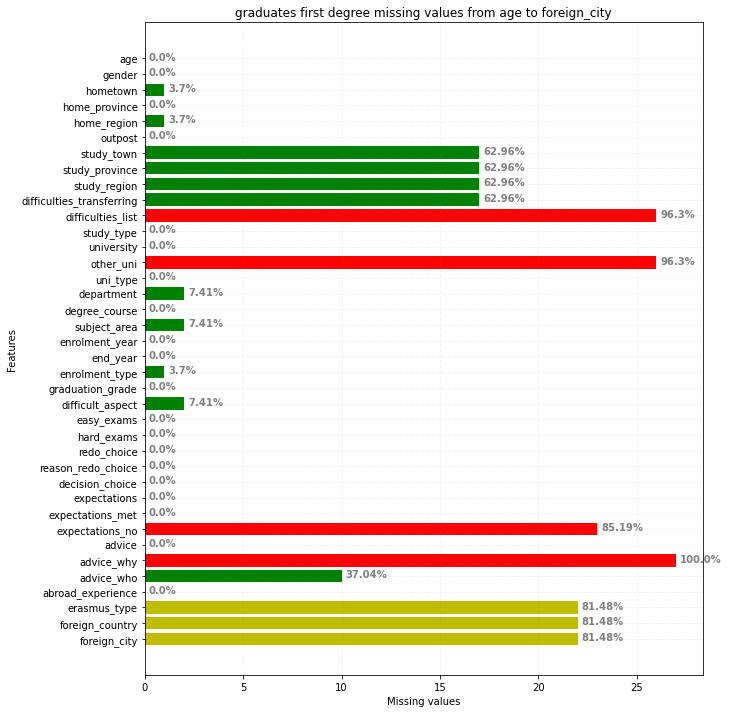

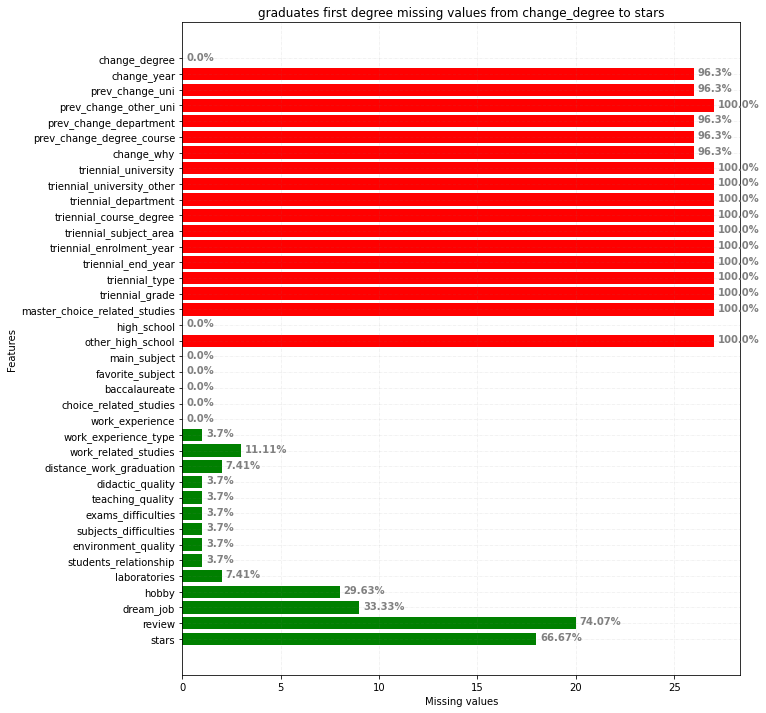

In [1058]:
missing_value_graphs(df_missing_value_first_degree_graduate, df_graduate_first_degree, 'graduates first degree')

##FEATURES SELECTION

In [1059]:
features_first_degree=['degree_course','other_high_school','high_school','main_subject', 'favorite_subject', 'dream_job', 'hobby', 'decision_choice' , 'expectations', 'choice_related_studies'  ]

##Unisco sia gli studenti che i laurati per le feature che ci interessano

In [1060]:
all_features_dict={}
for feature in features_first_degree:
  all_features=df_students_first_degree[feature]
  all_features=all_features.append(df_graduate_first_degree[feature], ignore_index=True, verify_integrity=True)
  all_features_dict[feature]=all_features

df_all_features_first_degree=pd.DataFrame(all_features_dict)
print('total sample firt degree:',df_all_features_first_degree.shape[0] )
df_all_features_first_degree.head()

total sample firt degree: 579


,degree_course,other_high_school,high_school,main_subject,favorite_subject,dream_job,hobby,decision_choice,expectations,choice_related_studies
0,ingegneria aerospaziale,NaN,Liceo Scientifico,"Scienze,matematica,informatica",matematica,CERN o ASI,"Astronomia,musica","Passioni personali (spazio, meccanica, aerei etc)",NaN,SI
1,Economia e commercio,NaN,Liceo Scientifico,"matematica,fisica,scienze",matematica,consulente finanziario,videogiochi,la mia voglia di intraprendere questo percorso...,quello che sto vivendo,NO
2,Medicina,NaN,Liceo Classico,"Greco, latino,italiano",Non ne avevo una,Radiologo,"Ascoltare musica, vedere film",La predisposizione alla materia,Di riuscire a proseguire con facilità,NO
3,Medicina e chirurgia,NaN,Liceo Classico,"Latino, greco, italiano",Latino,Diventare un medico specializzato,Atletica,Ho sempre voluto fare questo mestiere,Sicuramente lungo e faticoso ma spero soddisfa...,NO
4,Infermieristica,NaN,Liceo Classico,"Greco, latino, italiano, letteratura, filosofia.",Filosofia,Infermiere di sala operatoria,"Musica (batteria), biliardo.",Il desiderio di poter dare una mano a chi ne h...,Tutto quello che ho effettivamente incontrato ...,NO


##GESTIONE VALORI MANCANTI

##eliminazione valori nulli da degree course

In [1062]:
df_all_features_first_degree=df_all_features_first_degree[df_all_features_first_degree['degree_course'].notna()]

###eliminazione valori nulli

In [1063]:
coloumn_no_missing_value={}
for key in all_features_dict:
  if key!='main_subject' and key!='other_high_school' and key!='degree_course':  #l'eliminazione o è già stata fatta o verrà fatta in un altro modo
    coloumn_no_missing_value[key] = df_all_features_first_degree[df_all_features_first_degree[key].notna()]
print('sample first degree original:',df_all_features_first_degree.shape[0])
coloumn_no_missing_value

sample first degree original: 579


{'choice_related_studies':                    degree_course  ...  choice_related_studies
 0        ingegneria aerospaziale  ...                      SI
 1           Economia e commercio  ...                      NO
 2                       Medicina  ...                      NO
 3          Medicina e chirurgia   ...                      NO
 4               Infermieristica   ...                      NO
 ..                           ...  ...                     ...
 574                   ingegneria  ...                      SI
 575         Medicina e chirurgia  ...                      SI
 576              Scienze motorie  ...                      NO
 577             Servizio Sociale  ...                      NO
 578  Beni Culturali e Spettacolo  ...                      SI
 
 [564 rows x 10 columns],
 'decision_choice':                    degree_course  ...  choice_related_studies
 0        ingegneria aerospaziale  ...                      SI
 1           Economia e commercio  ...       

###features main_subject gestione valori mancanti

In [1064]:
df_all_features_first_degree = df_all_features_first_degree[df_all_features_first_degree['high_school'].notna()]
school_whitout_subject= df_all_features_first_degree['high_school'].loc[df_all_features_first_degree['main_subject'].isnull()]

In [1065]:
full_subject=df_all_features_first_degree['main_subject']
high_school=np.array(df_all_features_first_degree['high_school'])
for x  in school_whitout_subject:
  subject=np.array(df_all_features_first_degree['main_subject'].loc[df_all_features_first_degree['high_school'].str.contains(x,na=False)][0:1])
  for i in range(0, len(high_school)):
    if (high_school[i]==x):
        full_subject[i]=np.array2string(subject)
df_all_features_first_degree['full_subject']=full_subject

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [1066]:
df_all_features_first_degree['main_subject']=df_all_features_first_degree['main_subject'].combine_first(df_all_features_first_degree['full_subject'])
df_all_features_first_degree[['main_subject', 'full_subject']].head(50)

,main_subject,full_subject
0,"Scienze,matematica,informatica","['Scienze,matematica,informatica']"
1,"matematica,fisica,scienze","['Scienze,matematica,informatica']"
2,"Greco, latino,italiano","Greco, latino,italiano"
3,"Latino, greco, italiano","Latino, greco, italiano"
4,"Greco, latino, italiano, letteratura, filosofia.","Greco, latino, italiano, letteratura, filosofia."
5,"Diritto, economia inglese, francese, spagnolo","Diritto, economia inglese, francese, spagnolo"
6,"Latino,greco,italiano,inglese","Latino,greco,italiano,inglese"
7,"Economia, Diritto, Relazioni internazionali, M...","Economia, Diritto, Relazioni internazionali, M..."
8,"Scienze, matematica, fisica","['Scienze,matematica,informatica']"
9,"Matematica,scienze,fisica,chimica","['Scienze,matematica,informatica']"


In [1067]:
df_all_features_first_degree=df_all_features_first_degree.drop(['full_subject'], axis=1) #elimino colonna d'appoggio

Eliminazione eventuali valori nulli rimasti ed aggiunta al dizionario con il resto delle colonne pulite

In [1068]:
coloumn_no_missing_value['main_subject'] = df_all_features_first_degree[df_all_features_first_degree['main_subject'].notna()] #eliminazioni eventuali valori nulli rimasti


##Suddivido i singoli dataset

In [1069]:
dataframe_dict={} #è un dizionario che conterrà un dataframe per ogni analisi, per ora mancano le main_subject
for key in coloumn_no_missing_value.keys():
  if key=='high_school':
    dataframe_dict[key]=coloumn_no_missing_value[key][['degree_course', key, 'other_high_school']]
  else:
    dataframe_dict[key]=coloumn_no_missing_value[key][['degree_course', key]]
  print(key, "analysis sample:", dataframe_dict[key].shape[0])
  print(key, "analysis name coloumns:", dataframe_dict[key].columns)

high_school analysis sample: 570
high_school analysis name coloumns: Index(['degree_course', 'high_school', 'other_high_school'], dtype='object')
favorite_subject analysis sample: 568
favorite_subject analysis name coloumns: Index(['degree_course', 'favorite_subject'], dtype='object')
dream_job analysis sample: 452
dream_job analysis name coloumns: Index(['degree_course', 'dream_job'], dtype='object')
hobby analysis sample: 461
hobby analysis name coloumns: Index(['degree_course', 'hobby'], dtype='object')
decision_choice analysis sample: 573
decision_choice analysis name coloumns: Index(['degree_course', 'decision_choice'], dtype='object')
expectations analysis sample: 560
expectations analysis name coloumns: Index(['degree_course', 'expectations'], dtype='object')
choice_related_studies analysis sample: 564
choice_related_studies analysis name coloumns: Index(['degree_course', 'choice_related_studies'], dtype='object')
main_subject analysis sample: 567
main_subject analysis name colo

##DATA CLEANING

In [1070]:
stop_ita = stopwords.words('italian')
stemmer = ItalianStemmer()
def preprocessing_text(dataframe, feature, key): 
  feature =dataframe.apply(lambda row: nltk.word_tokenize(row[key]), axis=1)
  feature=feature.apply(lambda x: [item for item in x if item not in stop_ita]) #eliminaz stop word 
  feature=feature.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word
  return feature
def data_cleaning(feature):
  feature=feature.apply(lambda x: x.lower()) #minuscolo
  feature=feature.str.strip() #eliminaz spazi bianchi inizio e fine
  feature=feature.str.replace(r'\s\s+', ' ') #eliminaz doppi spazi
  for char in string.punctuation:
    feature=feature.str.replace(char, ' ')
  return feature



###merge high school to other high school




In [1071]:
dataframe_dict['high_school']=dataframe_dict['high_school'].replace('altro', np.NaN ) #necessario per effettuare merge tra 2 colonne
#dataframe_dict['high_school'].head(50)

In [1072]:
#dataframe_dict[key dictionary][column ddataframe]
dataframe_dict['high_school']['high_school']=dataframe_dict['high_school']['high_school'].combine_first(dataframe_dict['high_school']['other_high_school'])
#dataframe_dict['high_school'].columns

In [1073]:
dataframe_dict['high_school']['high_school']=dataframe_dict['high_school']['high_school'].replace(np.NaN,'altro') #necessario per effettuare merge tra 2 colonne
#dataframe_dict['high_school'].head()

In [1074]:
dataframe_dict['high_school']=dataframe_dict['high_school'][['degree_course', 'high_school']] #elimino colonna d'appoggio other_high_course
dataframe_dict['high_school']

,degree_course,high_school
0,ingegneria aerospaziale,Liceo Scientifico
1,Economia e commercio,Liceo Scientifico
2,Medicina,Liceo Classico
3,Medicina e chirurgia,Liceo Classico
4,Infermieristica,Liceo Classico
...,...,...
574,ingegneria,Istituto tecnico geometri
575,Medicina e chirurgia,Liceo Scientifico
576,Scienze motorie,Istituto tecnico economico
577,Servizio Sociale,Liceo Scientifico


###Cleaning dei dati

####Aggiunta delle colonne con i dati puliti

In [1075]:
categorical_features=['high_school', 'choice_related_studies']
for feature in dataframe_dict.keys():
  dataframe_dict[feature][feature]=data_cleaning(dataframe_dict[feature][feature]) #recupero solo la colonna che mi interessa...non lo faccio su degree_course
  if feature not in categorical_features:
    dataframe_dict[feature][feature]=preprocessing_text(dataframe_dict[feature],dataframe_dict[feature][feature], feature)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [1076]:
dataframe_dict['high_school'].head()

,degree_course,high_school
0,ingegneria aerospaziale,liceo scientifico
1,Economia e commercio,liceo scientifico
2,Medicina,liceo classico
3,Medicina e chirurgia,liceo classico
4,Infermieristica,liceo classico


In [1077]:
dataframe_dict['main_subject'].head()

,degree_course,main_subject
0,ingegneria aerospaziale,"[scienz, matemat, informat]"
1,Economia e commercio,"[matemat, fisic, scienz]"
2,Medicina,"[grec, latin, ital]"
3,Medicina e chirurgia,"[latin, grec, ital]"
4,Infermieristica,"[grec, latin, ital, letteratur, filosof]"


In [1078]:
dataframe_dict['favorite_subject'].head()

,degree_course,favorite_subject
0,ingegneria aerospaziale,[matemat]
1,Economia e commercio,[matemat]
2,Medicina,[]
3,Medicina e chirurgia,[latin]
4,Infermieristica,[filosof]


In [1079]:
dataframe_dict['dream_job'].head()

,degree_course,dream_job
0,ingegneria aerospaziale,"[cern, asi]"
1,Economia e commercio,"[consulent, finanziar]"
2,Medicina,[radiolog]
3,Medicina e chirurgia,"[divent, medic, specializz]"
4,Infermieristica,"[inferm, sal, operator]"


In [1080]:
dataframe_dict['hobby'].head()

,degree_course,hobby
0,ingegneria aerospaziale,"[astronom, music]"
1,Economia e commercio,[videogioc]
2,Medicina,"[ascolt, music, ved, film]"
3,Medicina e chirurgia,[atlet]
4,Infermieristica,"[music, batter, biliard]"


In [1081]:
dataframe_dict['decision_choice'].head()

,degree_course,decision_choice
0,ingegneria aerospaziale,"[passion, personal, spaz, meccan, aere, etc]"
1,Economia e commercio,"[vogl, intraprend, percors, stud]"
2,Medicina,"[predisposizion, mater]"
3,Medicina e chirurgia,"[sempr, vol, far, mest]"
4,Infermieristica,"[desider, poter, dar, man, bisogn]"


In [1082]:
dataframe_dict['expectations'].head()

,degree_course,expectations
1,Economia e commercio,[viv]
2,Medicina,"[riusc, prosegu, facil]"
3,Medicina e chirurgia,"[sicur, lung, fatic, sper, soddisfacent, fin]"
4,Infermieristica,"[effett, incontr, percors, fors, men, mater, u..."
5,Montaggio Cinematografico e Televisivo,"[aspett, riusc, impar, mest, molt, cors, pratic]"


In [1083]:
dataframe_dict['choice_related_studies'].head()

,degree_course,choice_related_studies
0,ingegneria aerospaziale,si
1,Economia e commercio,no
2,Medicina,no
3,Medicina e chirurgia,no
4,Infermieristica,no


#FEATURES ENGINEERING

###Caratteristiche nominali -> choice_related_studies

In [1084]:
encoder = LabelEncoder()
def one_hot_encoding(feature, key):
  genre_labels = encoder.fit_transform(feature) #all_choice è il dataframe che ho pulito prima
  genre_mappings = {index: label for index, label in enumerate(encoder.classes_)}
  feature=genre_labels
  print('encoding', key, ':',  genre_mappings)
  return feature


In [1085]:
for feature in categorical_features:
  dataframe_dict[feature][feature]=one_hot_encoding( dataframe_dict[feature][feature], feature)

encoding high_school : {0: 'altro', 1: 'ipsia', 2: 'istituto professionale agrario ', 3: 'istituto professionale alberghiero', 4: 'istituto professionale economico ', 5: 'istituto tecnico agrario', 6: 'istituto tecnico alberghiero', 7: 'istituto tecnico economico', 8: 'istituto tecnico geometri', 9: 'istituto tecnico grafica e comunicazione', 10: 'istituto tecnico industriale', 11: 'liceo artistico', 12: 'liceo classico', 13: 'liceo linguistico', 14: 'liceo musicale', 15: 'liceo scientifico', 16: 'liceo scienze umane'}
encoding choice_related_studies : {0: 'no', 1: 'si'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1086]:
dataframe_dict['high_school'].head()

,degree_course,high_school
0,ingegneria aerospaziale,15
1,Economia e commercio,15
2,Medicina,12
3,Medicina e chirurgia,12
4,Infermieristica,12


In [1087]:
dataframe_dict['choice_related_studies'].head()

,degree_course,choice_related_studies
0,ingegneria aerospaziale,1
1,Economia e commercio,0
2,Medicina,0
3,Medicina e chirurgia,0
4,Infermieristica,0


# DATI MAGISTRALI

In [1088]:
df_students_second_degree = df_students.query('study_type == "Magistrale"')
#df_students_second_degree
df_students_second_degree.shape

(138, 79)

In [1089]:
df_graduate_second_degree = df_graduate.query('study_type == "Magistrale"')
#df_graduate_second_degree
df_graduate_second_degree.shape

(30, 76)

# CODICE DI BRUTTA

In [1090]:
_#numero di colonne con valori mancanti
print("Columns with Missing Values:",df_subject_area_analysis.columns[df_subject_area_analysis.isnull().any()].tolist())

NameError: ignored

In [ ]:
#numero di righe con valori mancanti
print("Number of rows with Missing Values::",df_subject_area_analysis.isnull().any(axis = 1).sum()) #???

In [ ]:
#stampa le righe con valori mancanti
null_data = df_subject_area_analysis[df_subject_area_analysis.isnull().any(axis=1)]
null_data

In [ ]:
#university = np.unique(df_subject_area_analysis['university'])
#print("Università presenti:", len(university))
#print(university)

https://pythoninoffice.com/use-fuzzy-string-matching-in-pandas/
https://stackoverflow.com/questions/13636848/is-it-possible-to-do-fuzzy-match-merge-with-python-pandas
https://www.youtube.com/watch?v=uxHnMG1Jz00
https://towardsdatascience.com/fuzzywuzzy-find-similar-strings-within-one-column-in-a-pandas-data-frame-99f6c2a0c212

In [ ]:
#!pip install fuzzywuzzy
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process
#df_subject_area_analysis_1 =df_subject_area_analysis.copy()
#df_subject_area_analysis_1
#matches= df_subject_area_analysis['degree_course'].apply(lambda x: process.extractOne(x, df_subject_area_analysis_1['degree_course'].to_list(),score_cutoff=80))
#df_subject_area_analysis[['degree_course']]

In [ ]:
#df=pd.DataFrame(list(matches), columns=['degree', 'match'])
#df

In [ ]:
#df_subject_area_analysis['degree_course']=df['degree']
#df_subject_area_analysis['degree_course']

https://stackoverflow.com/questions/49716597/group-similar-words-sentences-in-pandas-column